# Тестирование потерь производительности ввода-вывода в  docker 

Это тесты нереплицируемых дисков в Yandex Cloud.

Показатели IOPS таких дисков намного выше и различия должны быть заметнее./



Вообще-то, показатели iops в Yandex Cloud [зависят от размера диска](https://cloud.yandex.ru/ru/docs/compute/concepts/storage-read-write).

При использованных размерах 558Гб ожидаемые показатели IOPS должны составить 33600.


## Гипотеза

Гипотеза в том, что дополнительные слои абстракции в docker не могут создать сколько-нибудь заметного замедления работы и поэтому эксплуатация в Docker баз данных и прочих приложений с интенсивным вводом-выводом, вполне разумная идея.

## Запуск тестов

Использована популярная программа fio. 
Задание записано в файле [task.ini](task.ini)

В первом тесте fio запускался на хосте.

Во втором случае, сначала собирался образ с добавленной программой fio на основе ОС идентичной хостовой. То есть, debian-slim.
Далее, запускалась команда:
```
docker run -v /data/:/data/ -v ./task.ini:/data/task.ini -it pavlozt/deb-fio:latest bin/bash
```

## Обработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Было собрано несколько наборов данных, но будем использовать тот, где эффект ожидается большим.

In [2]:
# В этом репозитарии несколько папок с тестами

#dirmark='./network-ssd-nonreplicated'
#dirmark='./network-ssd-nonrep-558gb'
#dirmark='./network-ssd-nonrep-2'
dirmark='./network-ssd-nonrep-558gb-long'

In [3]:
docker= pd.read_csv(f"{dirmark}/docker-mount/test1_iops.1.log.gz",sep=',',names=['ts','iops','t','wtf1','wtf2'])
docker.head(3)

,ts,iops,t,wtf1,wtf2
0,250,33292,1,0,0
1,350,33440,1,0,0
2,450,33370,1,0,0


In [4]:
docker_read_iops=docker[docker.t==0][['iops']]
docker_write_iops=docker[docker.t==1][['iops']]

In [5]:
host= pd.read_csv(f"{dirmark}/host/test1_iops.1.log.gz",sep=',',names=['ts','iops','t','wtf1','wtf2'])
host.head(3)

,ts,iops,t,wtf1,wtf2
0,250,33332,1,0,0
1,350,33310,1,0,0
2,450,33530,1,0,0


In [6]:
host_read_iops=host[host.t==0][['iops']]
host_write_iops=host[host.t==1][['iops']]

## Средние значения

Обычным способом сравнения "на глаз" является сравнение общего времени работы fio или средних показателей. 
В простых случаях различия очевидны, но что если отличия слишком малы? Чтобы убедиться, что случайный шум не повлиял на  эксперимент, необходима статистическая процедура.  

В этом тесте программа fio записывает набор средних значений за равные промежутки времени. Показатель "IOPS" (io per second) по своей сути является усредненным показателем. 

Просто сравним средние значения. Возможна ситуация когда показатели в docker будут даже быстрее чем host.

In [7]:
print(docker_write_iops.iops.mean())
print(host_write_iops.iops.mean())

33351.49283094365
33356.09353117706


## Графики
сначала просто нарисуем iops чтобы оценить нет ли провалов вызванных огрехами тестирования.
И, возможно, даже увидим ненормальность распределения.

Один из графиков пустой, потому что для стабильности делался только лишь тест rw=write. 
Обычно график крутится вокруг декларированной в  Yandex Cloud производительности дисков.

<Axes: title={'center': 'host writes'}, xlabel='ts', ylabel='iops'>

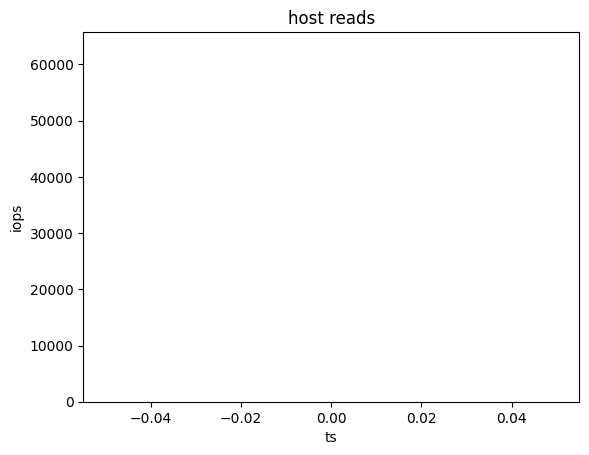

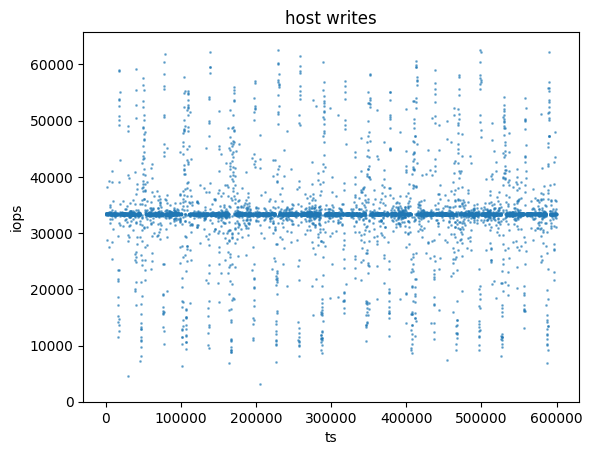

In [8]:
graphic_limit= host.iops.max()+0.05*host.iops.max()
host[host.t==0].plot.scatter(x='ts',y='iops',title='host reads',alpha=0.5,s=1,ylim=[0,graphic_limit])
host[host.t==1].plot.scatter(x='ts',y='iops',title='host writes',alpha=0.5,s=1,ylim=[0,graphic_limit])

<Axes: title={'center': 'docker writes'}, xlabel='ts', ylabel='iops'>

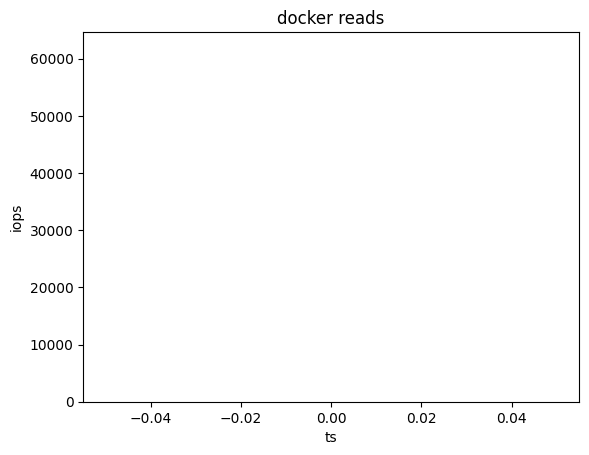

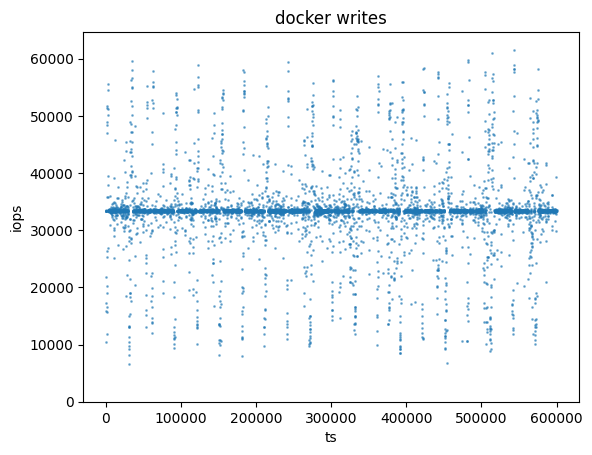

In [9]:
graphic_limit= docker.iops.max()+0.05*docker.iops.max()
docker[docker.t==0].plot.scatter(x='ts',y='iops',title='docker reads',alpha=0.5,s=1,ylim=[0,graphic_limit])
docker[docker.t==1].plot.scatter(x='ts',y='iops',title='docker writes',alpha=0.5,s=1,ylim=[0,graphic_limit])

## Замечание

На графике заметны выбросы и происходят они периодами.

## Контроль характера данных

Нужно убедиться что нет событий-проседаний. 
То есть, никакой burst не повлиял на тест, а показатели более-менее держатся в расчетных пределах.

Если наблюдается аномалия - не повезло, **переделываем** тест. 

Обычно это не нужно, так как тест fio выполнялся с "прогревом", а графики исчерпания показателя burst контролировались в консоли облака. 

In [10]:
host_write_iops['test_type']='host_write_iops'
docker_write_iops['test_type']='docker_write_iops'

In [11]:
host_write_iops

,iops,test_type
0,33332,host_write_iops
1,33310,host_write_iops
2,33530,host_write_iops
3,33520,host_write_iops
4,33340,host_write_iops
...,...,...
5993,32610,host_write_iops
5994,34250,host_write_iops
5995,33380,host_write_iops
5996,33380,host_write_iops


In [12]:
data = pd.concat([host_write_iops, docker_write_iops])
data

,iops,test_type
0,33332,host_write_iops
1,33310,host_write_iops
2,33530,host_write_iops
3,33520,host_write_iops
4,33340,host_write_iops
...,...,...
5993,33370,docker_write_iops
5994,33360,docker_write_iops
5995,33340,docker_write_iops
5996,33420,docker_write_iops


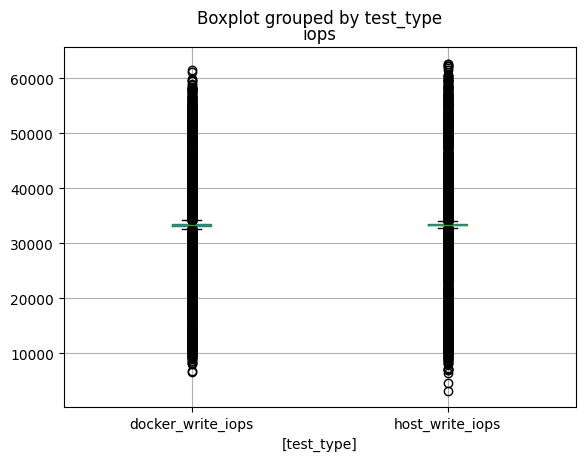

In [13]:
data.boxplot(by='test_type')
plt.show()

Выбросов многовато. Посмотрим еще и гистограмму.

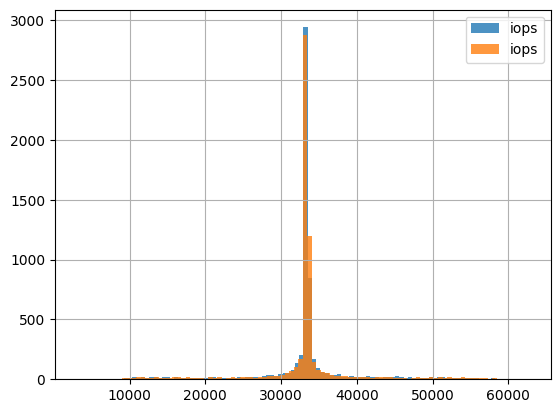

In [14]:
docker_write_iops['iops'].hist(bins=100,alpha=0.8,legend=True)
host_write_iops['iops'].hist(bins=100,alpha=0.8,legend=True)
#data.hist(column='iops',by='test_type',bins=100,legend=True)
plt.show()

## Еще немного графиков в другом стиле

In [15]:
import seaborn as sns

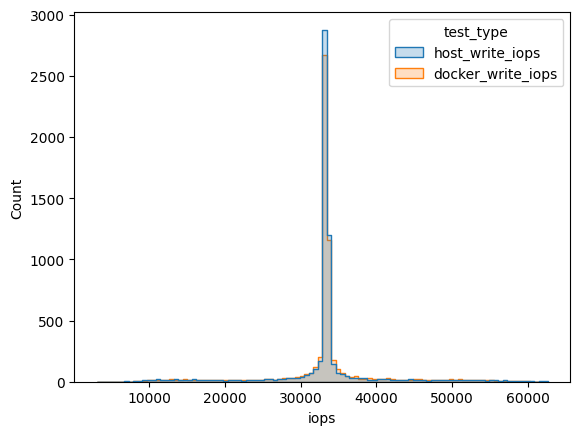

In [16]:
sns.histplot(data, x="iops", hue="test_type",element="step",bins=100);

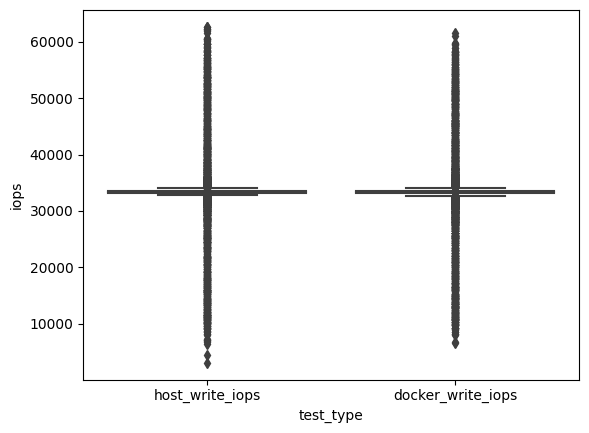

In [17]:
sns.boxplot(data=data, x="test_type", y="iops");

Для обычных статистических тестов  важно иметь нормально распределенные данные.

Возможно, произошли какие-то аномалии при сборе данных и хвосты слишком "тяжелые"
Самый простой способ - обрезать выбросы. 
Так же отрисуем этот ограниченный набор данных, чтобы оценить форму распределения визуально.

In [18]:
visualdata=data[(data.iops > 30000) & (data.iops < 37000)]

Теперь все повторяем:

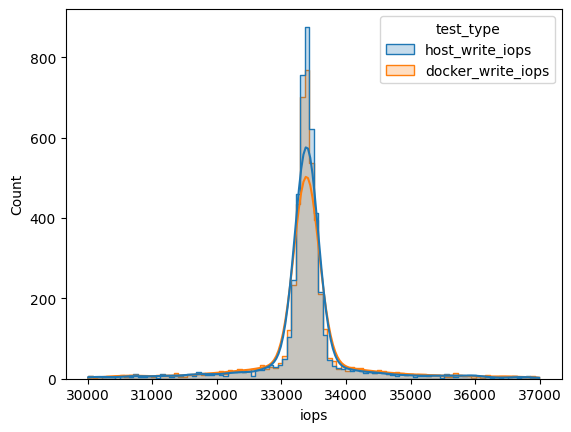

In [19]:
sns.histplot(visualdata, x="iops", hue="test_type",element="step",bins=100,kde=True);

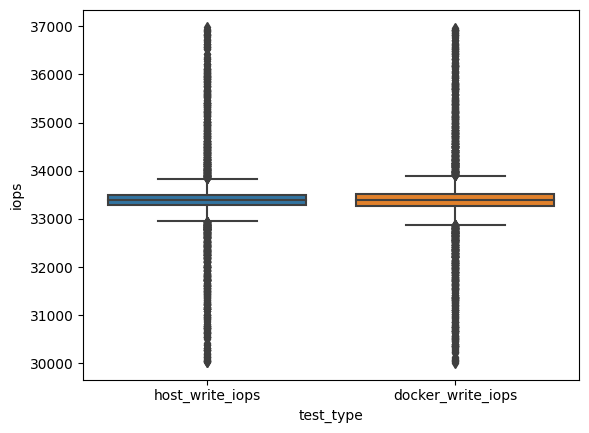

In [20]:
sns.boxplot(data=visualdata, x="test_type", y="iops");

## Проверка на нормальность

Прежде чем использовать обычный t-test, нужно убедиться что данные распределены нормально.

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

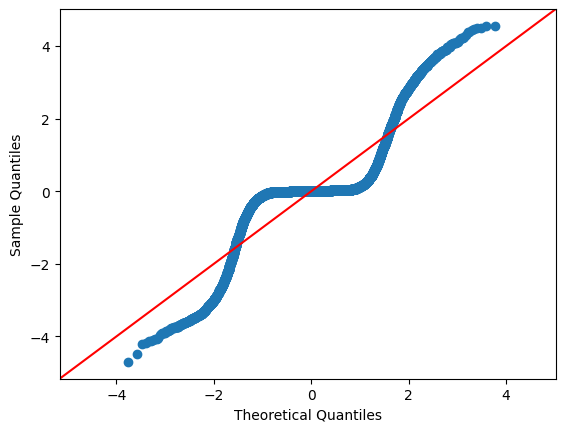

In [22]:
fig = sm.qqplot(data=data.iops.values,fit=True,line='45')

Нормальное распределение выглядит не так.

## Статистический тест
Надежней всего просто делать всегда перестановочные тесты.
В данной ситуации используем U-критерий Манна-Уитни. Но есть "противопоказания" - данных слишком много. 

In [23]:
from scipy import stats

In [24]:

stats.mannwhitneyu( host_write_iops['iops'],docker_write_iops['iops'])

MannwhitneyuResult(statistic=17996352.0, pvalue=0.9648823619482331)

## Остальные статистические тесты

t-test для полноты картины

In [25]:
stats.ttest_ind( host_write_iops['iops'],docker_write_iops['iops'])

TtestResult(statistic=0.03918498672990674, pvalue=0.9687435554727153, df=11994.0)

С такими показателям, считается что отличия невозможно подтвердить.

## Линейная модель (в стиле R)
Такие модели позволяют получать прямые коээфициенты в виде множителя - силу эффекта.
(код оставлен для случая если эффект все же проявится)

Сначала придется подготовить данные для этого стиля:

Поменяем тип факторной переменной "test_type" 

In [26]:
data.loc[:,'test_type']=data['test_type'].map({'docker_write_iops':0,'host_write_iops':1})
data.head(3)

,iops,test_type
0,33332,1
1,33310,1
2,33530,1


In [27]:
mod = smf.ols(formula='iops ~ test_type', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   iops   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.001535
Date:                Tue, 09 Jan 2024   Prob (F-statistic):              0.969
Time:                        13:10:36   Log-Likelihood:            -1.2221e+05
No. Observations:               11996   AIC:                         2.444e+05
Df Residuals:                   11994   BIC:                         2.444e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.335e+04     83.021    401.

# Вывод
Отличия не обнаружены.

Однако, замеченная сезонность и выбросы требуют дополнительного изучения.